In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
IMAGE_SIZE = [224, 224]
train_path = '/content/gdrive/MyDrive/FIRE-SMOKE-DATASET/Train/'
test_path = '/content/gdrive/MyDrive/FIRE-SMOKE-DATASET/Test/'

Working with 900 images.
Example Smoke Images: 
image_377.jpg


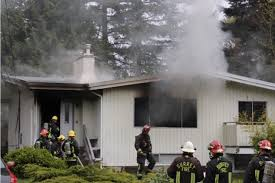

image_13.jpg


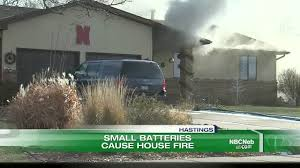

image_4.jpg


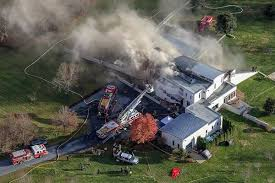

image_311.jpg


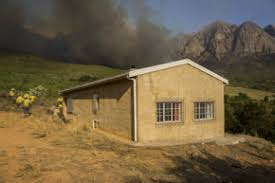

image_403.jpg


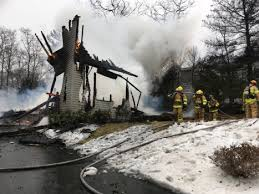

In [4]:
import os
from PIL import Image
from IPython.display import display
from IPython.display import Image as _imgdis

folder_smoke = train_path + 'Smoke/'

smoke_images = [f for f in os.listdir(folder_smoke) if os.path.isfile(os.path.join(folder_smoke, f))]
print('Working with {0} images.'.format(len(smoke_images)))
print('Example Smoke Images: ')

for i in range(5):
    print(smoke_images[i])
    display(_imgdis(filename=folder_smoke + '/' + smoke_images[i], width=320, height=240))

In [5]:
residual_network = ResNet50(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [6]:
for layer in residual_network.layers:
    layer.trainable = False

In [7]:
folders = glob('/content/gdrive/MyDrive/FIRE-SMOKE-DATASET/Train/*')
print(len(folders))

3


In [8]:
x = Flatten()(residual_network.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=residual_network.input, outputs=prediction)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_dataset = data_generator.flow_from_directory(train_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

test_dataset = data_generator.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 2700 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [12]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='resnet50_model.h5', verbose=1, save_best_only=False)
callbacks = [checkpoint]

start = datetime.now()

model_history = model.fit_generator(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    # steps_per_epoch=5,
    # validation_steps=32,
    callbacks=callbacks,
    verbose=1)

duration = datetime.now() - start
print('Training completed in time: ', duration)

Epoch 1/10
85/85 [==============================] - 883s 10s/step - loss: 2.4519 - accuracy: 0.8578 - val_loss: 2.5335 - val_accuracy: 0.8767

Epoch 00001: saving model to resnet50_model.h5
Epoch 2/10
85/85 [==============================] - 39s 458ms/step - loss: 1.7518 - accuracy: 0.9178 - val_loss: 3.0528 - val_accuracy: 0.8767

Epoch 00002: saving model to resnet50_model.h5
Epoch 3/10
85/85 [==============================] - 39s 462ms/step - loss: 1.6489 - accuracy: 0.9248 - val_loss: 3.1063 - val_accuracy: 0.8800

Epoch 00003: saving model to resnet50_model.h5
Epoch 4/10
85/85 [==============================] - 39s 461ms/step - loss: 1.3949 - accuracy: 0.9407 - val_loss: 7.0075 - val_accuracy: 0.7967

Epoch 00004: saving model to resnet50_model.h5
Epoch 5/10
85/85 [==============================] - 39s 458ms/step - loss: 1.6821 - accuracy: 0.9337 - val_loss: 3.0599 - val_accuracy: 0.9067

Epoch 00005: saving model to resnet50_model.h5
Epoch 6/10
85/85 [============================

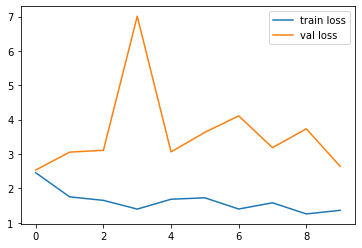

<Figure size 432x288 with 0 Axes>

In [13]:
# loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

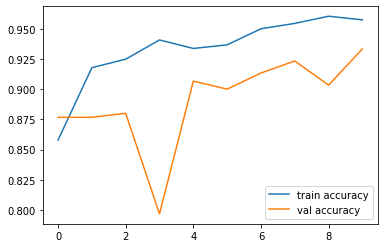

<Figure size 432x288 with 0 Axes>

In [14]:
# accuracies
plt.plot(model_history.history['accuracy'], label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')